# Chapter 6. 학습 관련 기술들

## 6.1 매개변수 갱신

신경망 학습의 목적은 손실 함수의 값을 가능한 한 낮추는 매개변수를 찾는 것이며, 이는 곧 매개변수의 최적값을 찾는 문제이며, 이러한 문제를 푸는 것을 **최적화(optimization)**이라 한다. 하지만, 매개변수 공간은 매우 넓고 복잡하기에 신경망 최적화는 굉장히 어려운 문제이다. (공간을 무작정 찾는 것)

이를 해결하기 위해, 우리는 최적의 매개변수 값을 찾기 위해 확률적 경사 하강법(SGD)을 사용했다. 이는 매개변수의 기울기(미분)을 구해, 기울어진 방향으로 매개변수 값을 갱신하는 일을 몇 번이고 반복해 점점 최적의 값에 다가가는 방법이다.

SGD의 단점을 알아본 후 SGD와 다른 최적화 기법을 알아보자.

### 6.1.1 모험가 이야기

(생략)

결론은 지금 서 있는 장소에서 가장 크게 기울어진 방향으로 가자는 것이 SGD의 전략이다. 이 일을 반복하면 언젠가 '깊은 곳'에 찾아갈 수 있을지도 모르지만, 과연 그럴까?

### 6.1.2 확률적 경사 하강법(SGD)

- $W$: 갱신할 가중치 매개변수
- $\frac{\partial L}{\partial W}$: $W$에 대한 손실 함수의 기울기
- $\eta$: 학습률
- $\leftarrow$: 우변의 값으로 좌변의 값 갱신

$$
W \leftarrow W - \eta \frac{\partial L}{\partial W}
$$



In [ ]:
class SGD:
  def __init__(self, lr=0.01):
    self.lr = lr

  def update(self, params, grads):
    for key in params.keys():
      params[key] -= self.lr * grads[key]

In [ ]:
# SGD 클래스 사용
network = TwoLayerNet(...)
optimizer = SGD()
# optimizer = Momentum()

for i in range(10000):
  ...
  x_batch, t_batch = get_mini_batch(...) # 미니배치
  grads = network.gradient(x_batch, t_batch)
  params = network.params
  optimizer.update(params, grads)
  ...

최적화를 담당하는 클래스를 분리해 구현하면 기능을 모듈화하기 좋다.

### 6.1.3 SGD의 단점

SGD는 단순하고 구현도 쉽지만, 문제에 따라서는 비효율적일 때가 있다.

이번 절에서는 아래 문제를 통해 알아보자. (함수의 최솟값을 구하는 문제)

$$
f(x, y) = \frac{1}{20}x^2 + y^2
$$


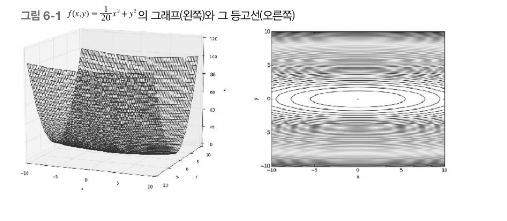

위 함수의 기울기를 그려보면 다음과 같이 y축 방향은 크고 x축 방향은 작다는 것이 특징이다. (즉, y축 방향은 가파른데 x축 방향은 완만)

또한, 주의할 점으로 최솟값이 되는 장소는 (x, y) = (0, 0)이지만, 다음 그림이 보여주는 기울기 대부분은 (0, 0) 방향을 가리키지 않는다는 것이다.

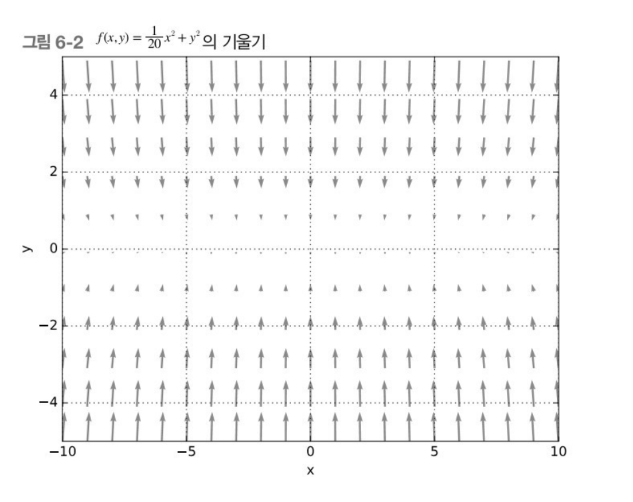

이제 위의 함수에 SGD를 적용해 보자. (탐색을 시작하는 장소인 초깃값은 (x, y) = (-7.0, 2.0))

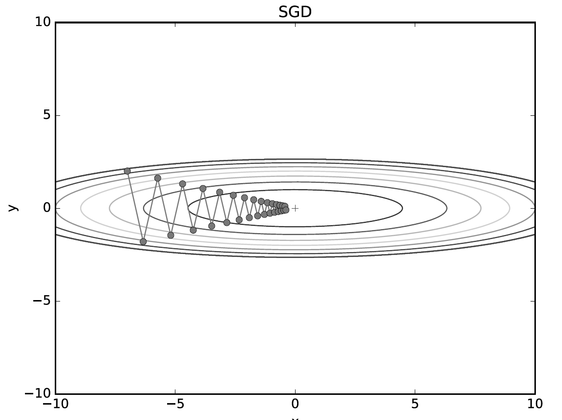

위 그림을 보면 SGD는 심하게 굽이진 비효율적인 움직임을 보여주는데, 즉 SGD의 단점은 비등방성(anisotropy) 함수 (방향에 따라 성질, 즉 여기에서는 기울기가 달라지는 함수)에서는 탐색 경로가 비효율적이라는 것이다.

또한, SGD가 지그재그로 탐색하는 근본 원인은 기울어진 방향이 본래의 최솟값과 다른 방향을 가리켜서라는 점도 생각해 볼 필요가 있다.

SGD의 이러한 단점을 개선해 주는 모멘텀, AdaGrad, Adam이라는 세 방법을 소개하겠다.

### 6.1.4 모멘텀 (Momentum)

: '운동량'을 뜻하는 단어로, 물리와 관계 있음.

$$
v \leftarrow \alpha v - \eta \frac{\partial L}{\partial W}
$$

$$
W \leftarrow W + v
$$

- $W$: 갱신할 가중치 매개변수
- $\frac{\partial L}{\partial W}$: $W$에 대한 손실 함수의 기울기
- $\eta$: 학습률
- $v$: 속도(velocity) 변수
- $\alpha v$: 물체가 아무런 힘을 받지 않을 때 서서히 하강시키는 역할. 즉 물리에서의 지면 마찰이나 공기 저항 (0.9 등 값으로 설정)

모멘텀은 공기 그릇의 바닥을 구르는 듯한 움직임을 보여준다.

In [1]:
class Momentum:
  def __init__(self, lr=0.01, momentum=0.9):
    self.lr = lr
    self.momentum = momentum
    self.v = None

  def update(self, params, grads):
    if self.v is None:
      self.v = {} # v는 update()가 처음 호출될 때 매개변수와 같은 구조의 데이터를 딕셔너리 변수로 저장
      for key, val in params.items():
        self.v[key] = np.zeros_like(val)

    for key in params.keys():
      self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
      params[key] += self.v[key]

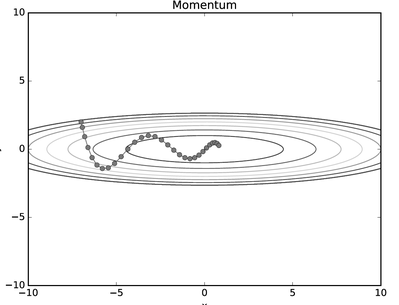

SGD와 비교하면 Momentum의 갱신 경로는 공이 그릇 바닥을 구르듯 움직인다.
- x축의 힘은 아주 작지만 방향은 변하지않아 한 방향으로 일정히 가속
- y축의 힘은 크지만 위아래로 번갈아 받아서 상충하여 y축 방향의 속도는 안정적이지 않음
- 전체적으로 SGD보다 x축 방향으로 빠르게 다가가 지그재그 움직임이 줄어든다.

### 6.1.5 AdaGrad

신경망 학습에서는 학습률이 중요하다.
- 작다면 학습 시간 길어짐
- 크다면 발산하여 학습이 제대로 이뤄지지 않음

이 학습률을 정하는 기술로 학습률 감소 (learning rate decay)가 있다. 이는 학습을 진행하면서 학습률을 점차 줄여가는 방법이다. 학습률을 서서히 낮추는 가장 간단한 방법은 매개변수의 '전체'의 학습률 값을 일괄적으로 낮추는 것, 이를 더욱 발전시킨 것이 AdaGrad이다.

AdaGrad는 '각각의' 매개변수에 '맞춤형' 값을 만들어준다. 즉, 개별 매개변수에 적응적으로(adaptvie) 학습률을 조정하면서 학습을 진행한다.

$$
h \leftarrow h + \frac{\partial L}{\partial W} \odot \frac{\partial L}{\partial W}
$$

$$
W \leftarrow W + \eta \cdot \frac{1}{\sqrt{h}} \cdot \frac{\partial L}{\partial W}
$$

- $h$: 기존 기울기 값을 제곱해서 계속 더해줌. 그리고 매개변수를 갱신할 때 $\frac{1}{\sqrt{h}}$ 을 곱해 학습률을 조정함.

매개변수의 원소 중 많이 움직인(크게 갱신된) 원소는 학습률이 낮아진단 뜻인데, 다시 말해 학습률 감소가 매개변수의 원소마다 다르게 적용됨을 뜻한다.



> AdaGrad

AdaGrad는 과거의 기울기를 제곱하여 계속 더해가는데, 그래서 학습을 진행할수록 갱신 강도가 약해진다. 이렇게 무한히 학습한다면 어느 순간 갱신량이 0이 되어 전혀 갱신되지 않게 된다.

위를 개선한 기법으로 RMSProp이 있는데, 이는 과거의 모든 기울기를 균일하게 더해가는 것이 아니라 먼 과거의 기울기는 서서히 잊고 새로운 기울기 정보를 크게 반영하는 지수이동평균(Exponential Moving Average, EMA)을 이용한다. (과거 기울기의 반영 규모를 기하급수적으로 감소)



In [ ]:
class AdaGrad:
  def __init__(self, lr=0.01):
    self.lr = lr
    self.h = None

  def update(self, params, grads):
    if self.h is None:
      self.h = {}
      for key, val in params.items():
        self.h[key] = np.zeros_like(val)

    for key in params.keys():
      self.h[key] += grads[key] * grads[key]
      params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)
      # 위 1e-7이라는 작은 값은 self.h[key]에 0이 담겨 있다 해도 0으로 나누는 사태를 막아준다.

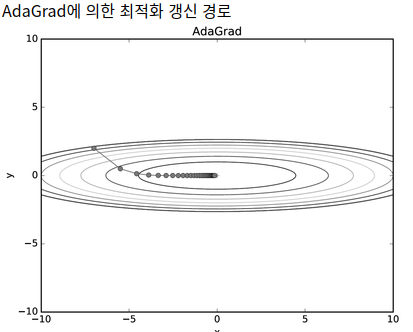

- y축 방향은 기울기가 커서 처음엔 크게 움직이지만, 그 큰 움직임에 비례해 갱신 정도도 큰 폭으로 작아지도록 조정됨
- 그래서 y축 방향으로 갱신 강도가 빠르게 약해지고, 지그재그 움직임이 줄어든다.

### 6.1.6 Adam

- 모멘텀: 공이 그릇 바닥을 구르는 듯한 움직임
- AdaGrad: 매개변수의 원소마다 적응적으로 갱신 정도를 조정

이 두 기법을 융합한 것이 Adam이다. 매개변수 공간을 효율적으로 탐색해 줄 것, 하이퍼파라미터의 '편향 보정'이 진행된다는 점이 특징이다.

In [4]:
# coding: utf-8
import numpy as np

class SGD:

    """확률적 경사 하강법（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]


class Momentum:

    """모멘텀 SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]


class Nesterov:

    """Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)"""
    # NAG는 모멘텀에서 한 단계 발전한 방법이다. (http://newsight.tistory.com/224)

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]


class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class RMSprop:

    """RMSprop"""

    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])

            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

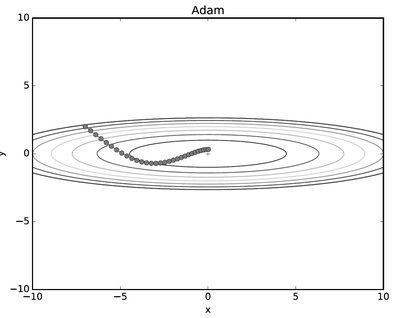

모멘텀과 비슷한 패턴을 보이지만, 그때보다 공의 좌우 흔들림이 적다. 이는 학습의 갱신 강도를 적응적으로 조정해서 얻는 혜택이다.

### 6.1.7 어느 갱신 방법을 이용할 것인가?

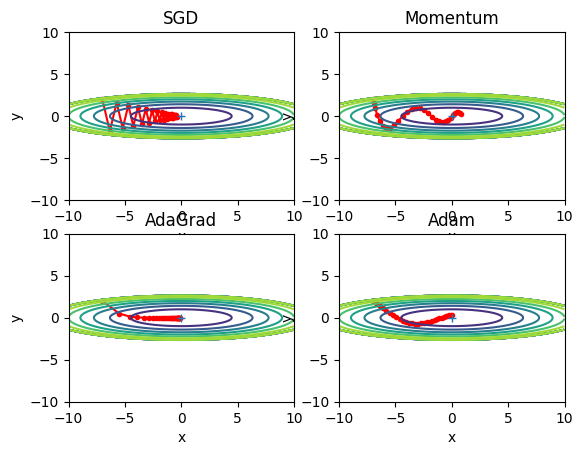

In [5]:
# coding: utf-8
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정

def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y


init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]

    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])

        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)

    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)

    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0

    # 그래프 그리기
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, '.-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    # colorbar()
    # spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")

plt.show()

위와 같이 사용한 기법에 따라 갱신 경로가 다른 것을 확인할 수 있다.

보기엔 AdaGrad가 가장 나은 것 같지만, 사실 그 결과는 풀어야 할 문제가 무엇이냐, 와 (학습률 등) 하이퍼파라미터를 어떻게 설정하느냐에 따라 결과가 바뀐다.

알아서 잘 채택할 것.

### 6.1.8 MNIST 데이터셋으로 본 갱신 방법 비교
- 실험은 각 층이 100개의 뉴런으로 구성된 5층 신경망에서 ReLU를 활성화 함수로 사용
- SGD의 학습 진도가 가장 느림

결론은 하이퍼파라미터인 학습률과 신경망의 구조(층 깊이 등)에 따라 결과가 달라질 것.

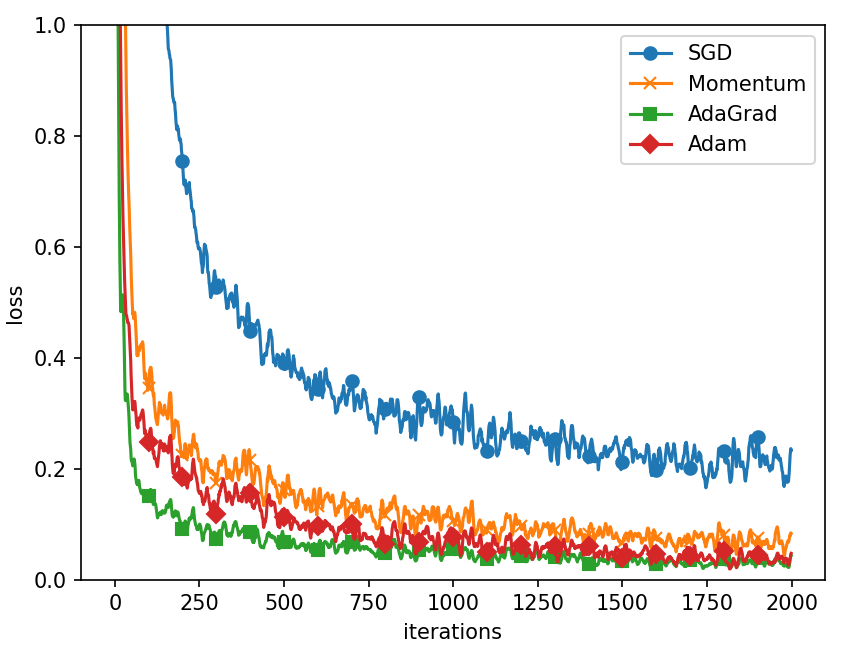

## 6.2 가중치의 초깃값

### 6.2.1 초깃값을 0으로 하면?

신경망 학습에서 특히 중요한 것이 가중치의 초깃값이며, 이를 무엇으로 설정하느냐가 중요하다.

오버피팅을 억제해 범용 성능을 높이는 테크닉인 가중치 감소(weight decay) 기법을 알아보자. 가중치 매개변수의 값을 작게 하기 위해서는 초깃값도 최대한 작은 값에서 시작하는 것이 좋다. (지금까지는 0.01*np.random.randn(10,100)처럼 정규분포에서 생성되는 값을 0.01배 한 작은 값(표준편차가 0.01인 정규분포)을 사용함)

그렇다면 가중치의 초깃값을 모두 0으로 설정한다면 어떨까? 이러면 학습이 올바로 이루어지지 않는다.

자세히 말해서, 초깃값을 모두 0으로 해서는 안 되는 이유가 뭘까? (정확히는 가중치를 균일한 값으로 설정해서는 안 됨) 그 이유는 바로 오차역전파법에서 모든 가중치의 값이 똑같이 갱신되기 때문이다. (층에서 층으로 넘어갈 때 '곱셈 노드 역전파'로 모두 같은 값이 전달됨)

이렇게 한다면 가중치를 여러 개 갖는 의미를 사라지게 한다. 따라서, 이 '가중치가 고르게 되어버리는 상황'을 막으려면 (가중치의 대칭적인 구조를 무너뜨리려면) 초깃값을 무작위로 설정해야 한다.

### 6.2.2 은닉층의 활성화값 분포

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100) # 1000개의 데이터
node_num = 100 # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5 # 은닉층이 5개
activations = {} # 이곳에 활성화 결과(활성화값)를 저장

for i in range(hidden_layer_size):
  if i != 0:
    x = activations[i-1]

  w = np.random.randn(node_num, node_num) * 1
  a = np.dot(x, w)
  z = sigmoid(a)
  activations[i] = z

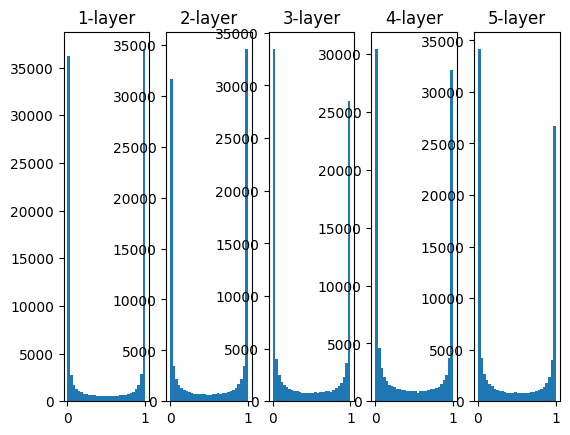

In [11]:
# 히스토그램 그리기
for i, a in activations.items():
  plt.subplot(1, len(activations), i+1)
  plt.title(str(i+1) + "-layer")
  plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

각 층의 활성화값들이 0과 1에 치우쳐 분포되어 있는 것을 확인할 수 있다. 여기서 사용한 시그모이드 함수는 그 출력이 0에 가까워지자(또는 1에 가까워지자) 그 미분은 0에 다가간다. 그래서 데이터가 0과 1에 치우쳐 분포하게 되면 역전파의 기울기 값이 점점 작아지다가 사라진다. 이것이 **기울기 소실(gradient vanishing)**이다. (층을 깊게 하는 딥러닝에서는 기울기 소실이 더 심각한 문제가 됨)

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100) # 1000개의 데이터
node_num = 100 # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5 # 은닉층이 5개
activations = {} # 이곳에 활성화 결과(활성화값)를 저장

for i in range(hidden_layer_size):
  if i != 0:
    x = activations[i-1]

  # 이번에는 가중치 표준편차를 0.01로
  # w = np.random.randn(node_num, node_num) * 1
  w = np.random.randn(node_num, node_num) * 0.01
  a = np.dot(x, w)
  z = sigmoid(a)
  activations[i] = z

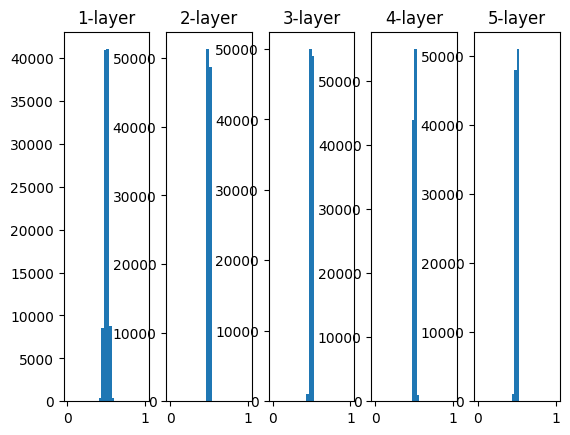

In [15]:
# 히스토그램 그리기
for i, a in activations.items():
  plt.subplot(1, len(activations), i+1)
  plt.title(str(i+1) + "-layer")
  plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

표준편차를 0.01로 한 정규분포의 경우 0.5 부근에 집중된 것을 볼 수 있다. 앞의 예처럼 0과 1로 치우치진 않았으니 기울기 소실 문제는 일어나지 않지만, 활성화값들이 치우쳤다는 것은 다수의 뉴런이 거의 같은 값을 출력하고 있어 뉴런을 여러 개 둔 의미가 없어진다. (표현력을 제한한다는 관점)

각 층의 활성화값은 적당히 고루 분포되어야 한다. 층과 층 사이에 적당히 다양한 데이터가 흐르게 해야 신경망 학습이 효율적으로 이뤄지기 때문. 반대로 치우친 데이터가 흐른다면 기울기 소실 or 표현력 제한 문제에 빠져 학습이 잘 이뤄지지 않는다.

이어서, Xavier Glorot와 Yoshua Bengio의 논문에서 권장하는 가중치 초깃값인, Xavier 초깃값을 사용해 보자. (표준)

이 논문에서는 각 층의 활성화값들을 광범위하게 분포시킬 목적으로 가중치의 적절한 분포를 찾고자 했으며, 앞 계층의 노드가 $n$개라면 표준편차가 $\frac{1}{\sqrt{n}}$ 인 분포를 사용하면 된다는 결론을 냈다.


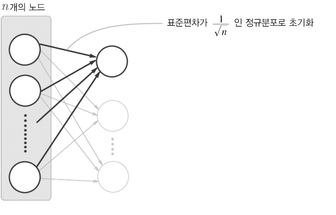

Xavier 초깃값을 사용하면 앞 층의 노드가 많을수록 대상 노드의 초깃값으로 설정하는 가중치가 좁게 퍼진다.

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100) # 1000개의 데이터
node_num = 100 # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5 # 은닉층이 5개
activations = {} # 이곳에 활성화 결과(활성화값)를 저장

for i in range(hidden_layer_size):
  if i != 0:
    x = activations[i-1]

  # 이번에는 Xavier 초깃값 사용
  # w = np.random.randn(node_num, node_num) * 1
  # w = np.random.randn(node_num, node_num) * 0.01
  w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
  a = np.dot(x, w)
  z = sigmoid(a)
  activations[i] = z

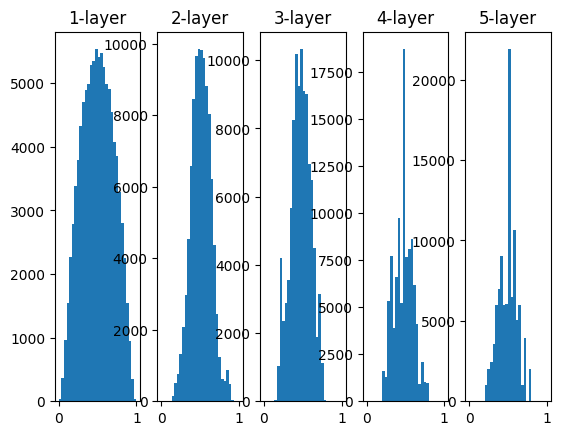

In [17]:
# 히스토그램 그리기
for i, a in activations.items():
  plt.subplot(1, len(activations), i+1)
  plt.title(str(i+1) + "-layer")
  plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

결과를 보면 층이 깊어지며 형태가 다소 일그러지지만, 앞의 예보다는 확실히 넓게 분포됨을 알 수 있다. 각 층에 흐르는 데이터는 적당히 퍼져 있으므로, 시그모이드 함수의 표현력도 제한받지 않고 학습이 효율적으로 이뤄질 것으로 기대함.

(활성화 함수용으로는 원점에서 대칭인 함수가 바람직)

### 6.2.3 ReLU를 사용할 때의 가중치 초깃값

Xavier 초깃값은 활성화 함수가 선형인 것을 전제로 이끈 결과다.
- sigmoid 함수, tanh 함수가 좌우 대칭이기에 중앙 부근이 선형인 함수로 볼 수 있음.
- 반면 ReLU를 이용할 때는 ReLU에 특화된 초깃값을 이용할 것. (이때, 특화된 초깃값을 He 초깃값이라 함)

Xavier 초깃값이 $\frac{1}{\sqrt{n}}$이었기에 ReLU는 음의 영역이 0이라 더 넓게 분포시키기 위해 2배의 계수가 필요함. 즉, He 초깃값은 앞 계층의 노드가 2개일 때, 표준편차가 $\sqrt{\frac{2}{n}}$인 정규분포를 사용한다.

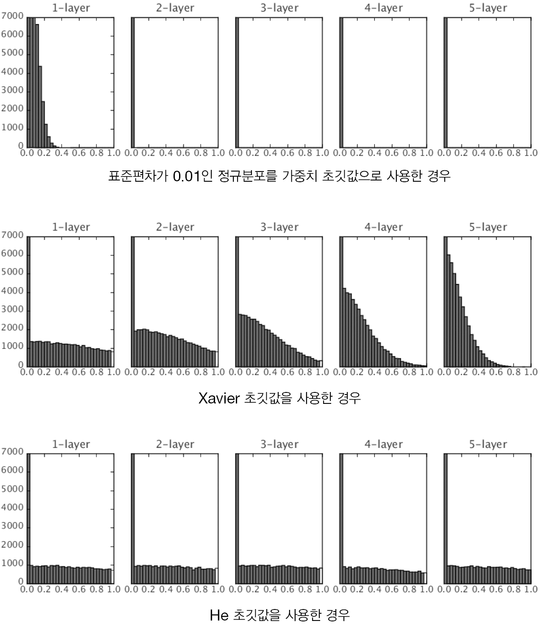

- std = 0.01 : 각 층의 활성화 값들은 아주 작은 값. 따라서 역전파 때 가중치의 기울기 역시 작아진다는 의미이므로 학습이 이뤄지지 않음.
- Xavier 초깃값 : 층이 깊어지며 활성화값들의 치우침이 점차 커지기에 학습할 때 '기울기 소실' 문제를 일으킴.
- He 초깃값 : 모든 층에서 균일히 분포되므로 역전파 때도 적절한 값이 나올 것.

위 실험 결과를 바탕으로, 활성화 함수 별 사용은 다음과 같음.
- ReLU : He 초깃값
- sigmoid, tanh 등 S자 모양 곡선 : Xavier 초깃값

### 6.2.4 MNIST 데이터셋으로 본 가중치 초깃값 비교

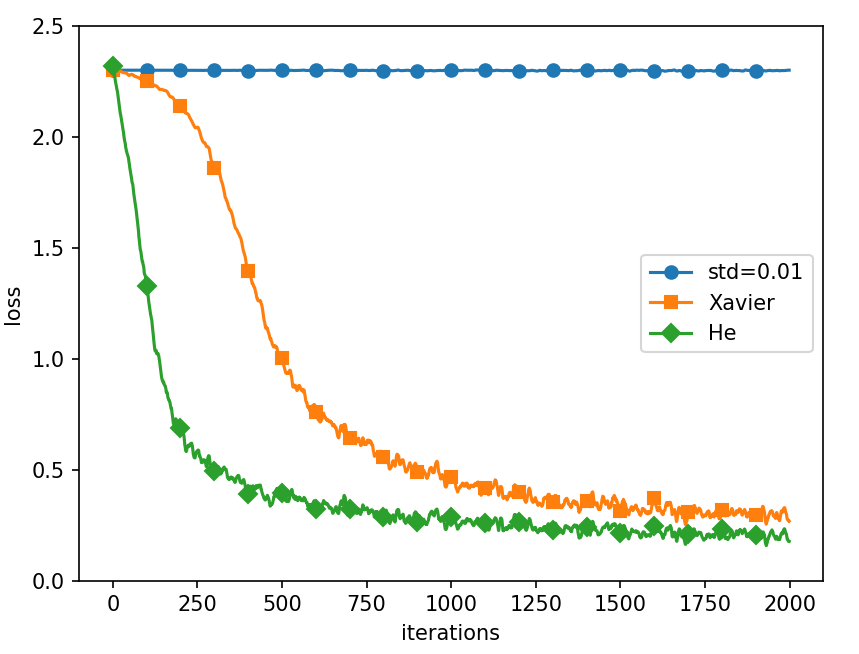

이 실험은 층별 뉴런 수가 100개인 5층 신경망에서 활성화 함수로 ReLU 사용.
- std = 0.01 : 학습이 전혀 이뤄지지 않음 (가중치 갱신 x)
- Xavier, He 초깃값 : 학습이 순조로움 (학습 진도는 He 초깃값이 더 빠름)

결론으로, 가중치 초깃값이 중요하다.

## 6.3 배치 정규화

앞 절에서는 가중치의 초깃값을 적절히 설정하면 각 층의 활성화값 분포가 적당히 퍼지며 학습이 원활히 수행됨을 알았다. 그렇다면 각 층이 활성화를 적당히 퍼뜨리도록 '강제'해 보면 어떨까? 이것이 '배치 정규화(Batch Normalization)'의 아이디어 기원.

### 6.3.1 배치 정규화 알고리즘

배치 정규화의 장점은 다음과 같다.
- 학습을 빨리 진행할 수 있다(학습 속도 개선)
- 초깃값에 크게 의존하지 않는다(초깃값 선택에 대한 골치성 제거)
- 오버피팅을 억제한다(드롭아웃 등 필요성 감소)

배치 정규화의 기본 아이디어는 각 층에서의 활성화값이 적당히 분포되도록 조정하는 것이다.

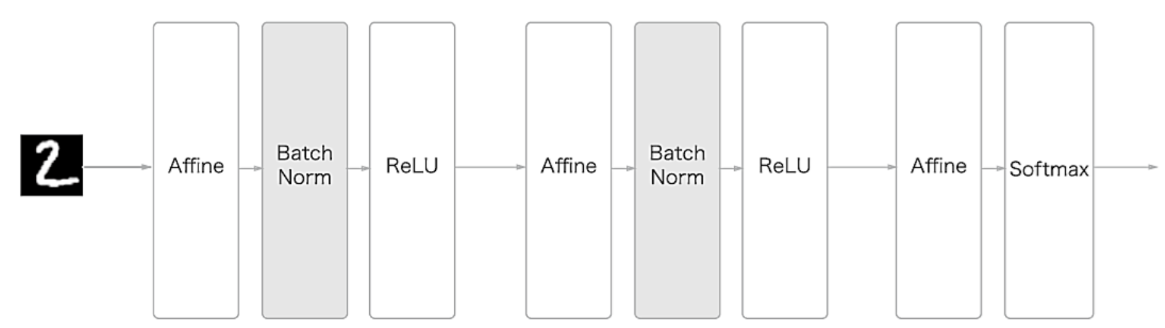

배치 정규화는 학습 시 미니배치 단위로 정규화를 한다. (데이터 분포가 평균이 0, 분산이 1이 되도록)

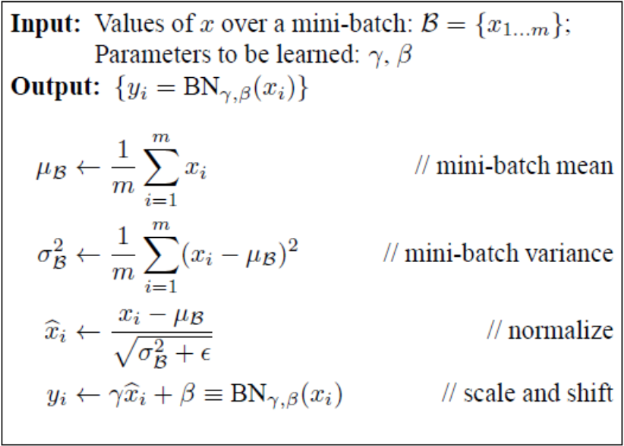

위 수식에서는
- 미니배치 $B$라는 $m$개의 입력 데이터의 집합에 대해 평균 $\mu_B$와 분산 $\sigma_B^2$을 구한다.
- 그리고 입력 데이터를 평균이 0, 분산이 1이 되게 (적절한 분포가 되게) 정규화
- $\epsilon$은 0으로 나누는 사태 예방
- $\gamma$가 확대, $\beta$가 이동을 담당. 두 값은 처음에는 $\gamma = 1$, $\beta=0$부터 시작하고, 학습하며 적합한 값으로 조정함

미니배치 입력 데이터의 정규화 처리를 활성화 함수의 앞(혹은 뒤)에 삽입함으로써 데이터 분포가 덜 치우치게 할 수 있다. 또, 배치 정규화 계층마다 이 정규화된 데이터에 고유한 확대(scale)와 이동(shift) 변환을 수행한다.

배치 정규화는 순전파 때 적용되며, 이 알고리즘의 계산 그래프는 다음과 같다.

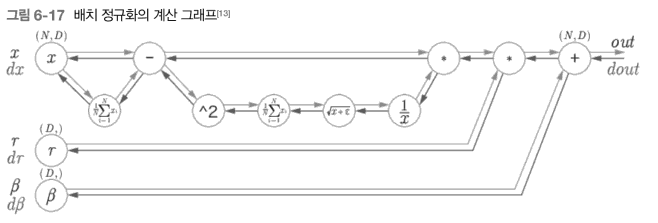

### 6.3.2 배치 정규화의 효과

아래는 MNIST 데이터셋을 사용하여 배치 정규화 계층을 사용할 때와 사용하지 않을 때의 학습 진도 차를 알아본다.

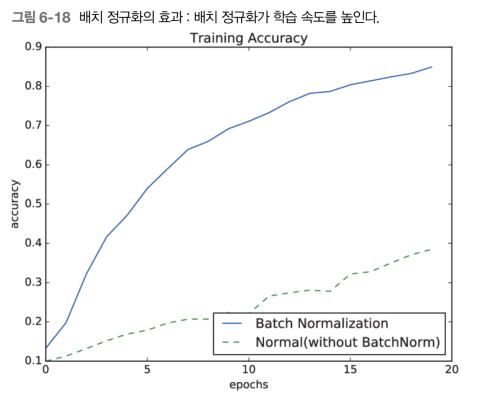

그리고, 아래는 초깃값 분포를 다양하게 바꿔가며 학습 경과를 관찰해 보았다.

거의 모든 경우에서 배치 정규화를 사용할 때의 학습 진도가 빠른 것을 확인할 수 있다.

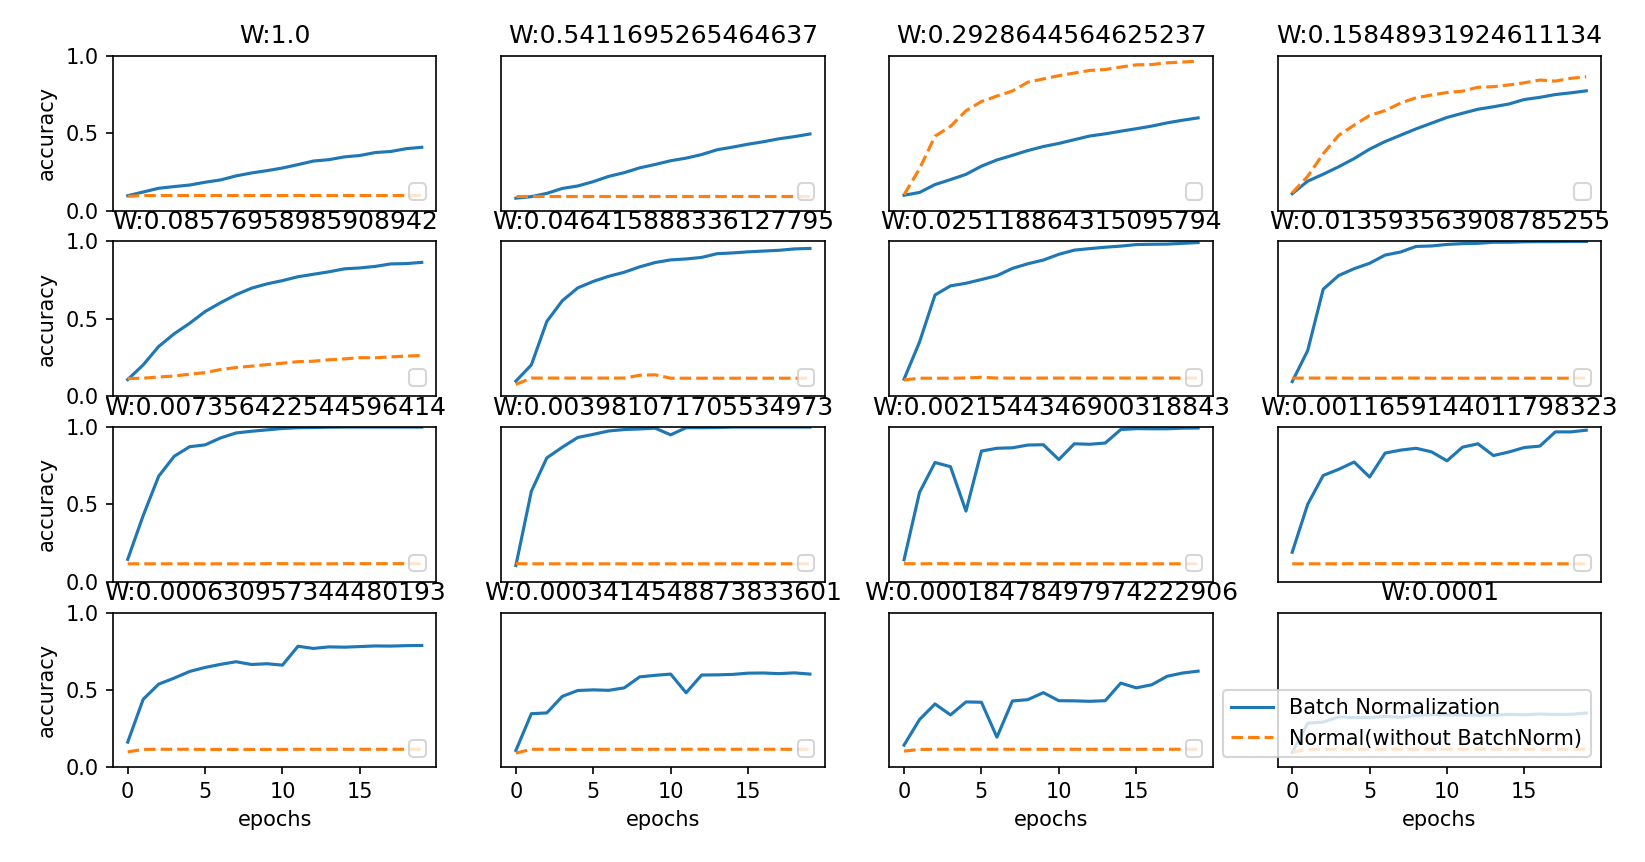

## 6.4 바른 학습을 위해

기계학습에서는 신경망이 훈련 데이터에만 지나치게 적응되어 그 외의 데이터에는 제대로 대응하지 못하는 상태인 **오버피팅**이 문제되는 경우가 많다.

### 6.4.1 오버피팅

오버피팅이 일어나는 경우는 주로 두 가지다.
- 매개변수가 많고 표현력이 높은 모델
- 훈련 데이터가 적음

이번 절에서는 이 두 요건을 일부러 충족하여 오버피팅을 일으켜보도록 한다. 이를 위해 다음의 조정을 한다.
- 원래 60000개인 MNIST 데이터셋의 훈련 데이터 중 300개만 사용
- 7층 네트워크를 사용해 네트워크 복잡성 높임
- 각 층의 뉴런은 100개
- 활성화 함수는 ReLU

In [ ]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

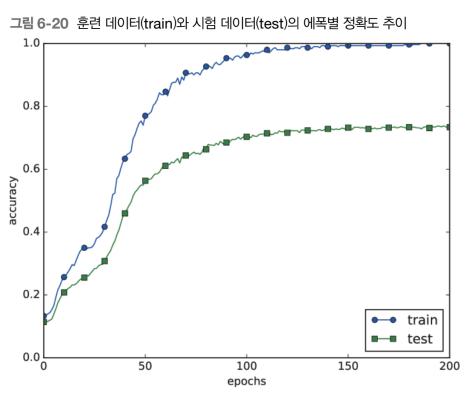

훈련 데이터를 사용하여 측정한 정확도는 100 에폭을 지나는 무렵부터 거의 100%이다. 그러나 시험 데이터에 대해서는 지나치게 정확도가 낮다. 이처럼 정확도 차이가 큰 것은 훈련 데이터에만 적응(fitting)해버린 결과이다. 훈련 때 사용하지 않은 범용 데이터(시험 데이터)에는 제대로 대응하지 못하는 것을 확인할 수 있다.

### 6.4.2 가중치 감소 (weight decay)

오버피팅 억제용으로 예로부터 많이 이용해온 방법 중 가중치 감소가 있는데, 이는 학습 과정에서 큰 가중치에 대해서는 그에 상응하는 큰 페널티를 부과하여 오버피팅을 억제하는 방법이다. (오버피팅이 가중치 매개변수의 값이 커서 발생하는 경우가 많기 때문)

신경망 학습의 목적은 손실 함수의 값을 줄이는 것이다.

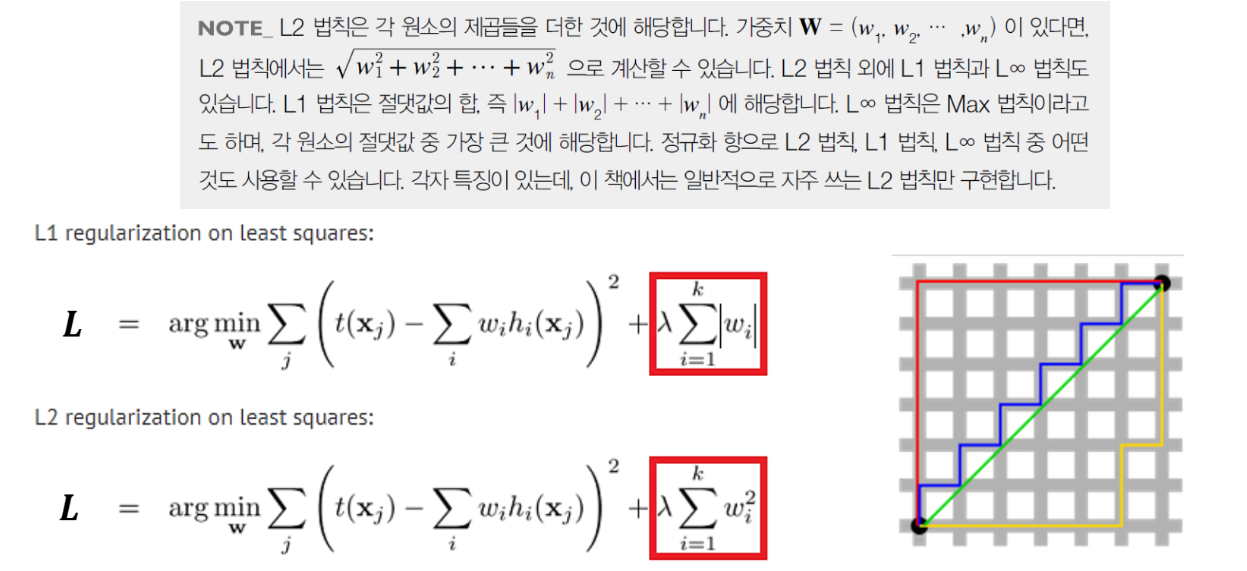

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class MultiLayerNet:
    """완전연결 다층 신경망

    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화

        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLU를 사용할 때의 권장 초깃값
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoid를 사용할 때의 권장 초깃값
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        손실 함수의 값
        """
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """기울기를 구한다(수치 미분).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads

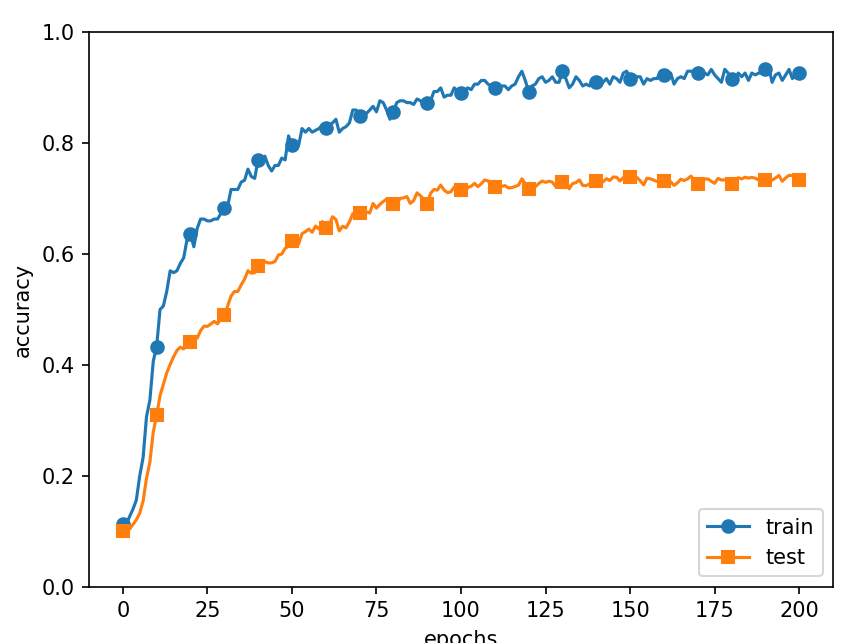

위는 $\lambda = 0.1$ 로 가중치 감소를 적용한 것이다. 훈련 데이터에 대한 정확도와 시험 데이터에 대한 정확도는 그전에 비해 정확도의 차이가 줄어든 것을 볼 수 있다. 즉, 오버피팅이 억제되었다는 소리이며, 그전과 달리 훈련 데이터에 대한 정확도가 100%(1.0)에 도달하지 못한 점도 주목해 보자.

### 6.4.3 드롭아웃

신경망 모델이 복잡해지면 가중치 감소만으로는 대응하기 어려워지는데, 이럴 때는 흔히 드롭아웃(Dropout)이라는 기법을 이용한다.

드롭아웃은 뉴런을 임의로 삭제하며 학습하는 방법이다. 훈련 때 은닉층의 뉴런을 무작위로 골라 삭제하며, 이 삭제된 뉴런은 신호를 전달하지 않게 된다. 시험 때는 모든 뉴런에 신호를 전달한다. 단, 시험 때는 각 뉴런의 출력에 훈련 때 삭제 안 한 비율을 곱하여 출력한다.

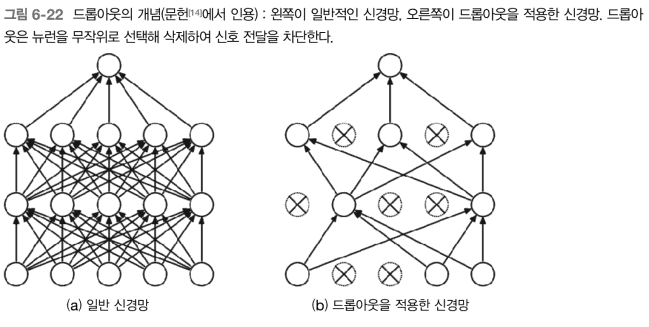

In [ ]:
class Dropout:
  def __init__(self, dropout_ratio=0.5):
    self.dropout_ratio = dropout_ratio
    self.mask = None

  def forward(self, x, train_flg=True):
    if train_flg:
      self.mask = np.random.rand(*x.shape) > self.dropout_ratio
      return x * self.mask
    else:
      return x * (1.0 - self.dropout_ratio)

  def backward(self, dout):
    return dout * self.mask

순전파
- 훈련 시에는 순전파 때마다 self.mask에 삭제할 뉴런을 False로 표시한다.
- self.mask는 x와 형상이 같은 배열을 무작위로 생성하고, 그 값이 dropout_ratio보다 큰 원소만 True로 설정한다.

역전파
- ReLU와 같음
- 순전파 때 신호를 통과시키는 뉴런은 역전파 때도 신호를 그대로 통과시키며, 순전파 때 통과시키지 않은 뉴런은 역전파 때도 신호를 차단한다.

In [ ]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784,
                              hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout,
                              dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
# epoch:301, train acc:0.73, test acc:0.6315

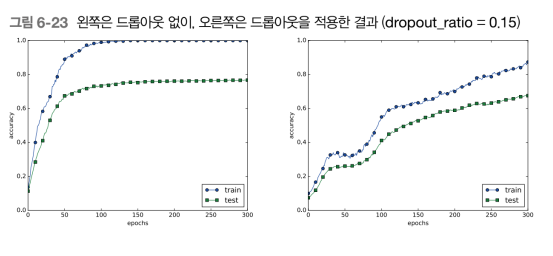

이제는 확연히 훈련과 시험 데이터에 대한 정확도 차가 줄어든 것을 볼 수 있으며, 훈련 데이터에 대한 정확도가 100%에 도달하지도 않게 되었다.


> 앙상블 학습



## 6.5 적절한 하이퍼파라미터 값 찾기

하이퍼파라미터의 예는 각 층의 뉴런 수, 배치 크기, 매개변수 갱신 시의 학습률과 가중치 감소 등이다. 이러한 값들을 적절히 설정하지 않으면 모델의 성능이 크게 떨어진다. 하지만 적절한 하이퍼파라미터 값을 설정하기 위해서는 많은 시행착오를 겪으므로, 이번 절에서는 최대한 효율적으로 값을 탐색하는 방법을 설명한다.

### 6.5.1 검증 데이터

- 훈련 데이터 : 매개변수 학습
- 검증 데이터 : 하이퍼파라미터 성능 평가
- 시험 데이터 : 신경망의 범용 성능 평가

In [ ]:
(x_train, t_train), (x_test, t_test) = load_mnist()

# 훈련 데이터를 뒤섞는다.
x_train, t_train = shuffle_dataset(x_train, t_train)

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

### 6.5.2 하이퍼파라미터 최적화

